In [1]:
# Pastikan library sudah terinstall:
# pip install kagglehub pandas

import kagglehub
import pandas as pd

# Gunakan KaggleDatasetAdapter dengan cara yang benar
from kagglehub import KaggleDatasetAdapter

# Tentukan dataset dari Kaggle
dataset = "amitzala/transportation-dataset"
file_path = "transportation-to-work-1.xlsx"

# Load dataset menggunakan KaggleHub
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS, # Pass adapter as positional argument
    dataset, # Pass dataset as positional argument
    file_path, # Pass file_path as positional argument
    pandas_kwargs={"sheet_name": 0}  # jika Excel punya beberapa sheet, bisa ubah di sini
)

# Tampilkan informasi dasar dataset
print("\n=== Informasi Dataset ===")
print(df.info())

print("\n=== Lima Data Teratas ===")
print(df.head())

print("\n=== Statistik Deskriptif =====")
print(df.describe(include='all'))

print("\n=== Nilai Kosong di Tiap Kolom ===")
print(df.isna().sum())

/tmp/ipython-input-1576330924.py:15: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 21.7M/21.7M [00:00<00:00, 80.1MB/s]



=== Informasi Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202203 entries, 0 to 202202
Data columns (total 24 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   ind_id          202203 non-null  object        
 1   ind_definition  202202 non-null  object        
 2   reportyear      202202 non-null  object        
 3   race_eth_code   202202 non-null  float64       
 4   race_eth_name   202202 non-null  object        
 5   geotype         202202 non-null  object        
 6   geotypevalue    202202 non-null  float64       
 7   geoname         202202 non-null  object        
 8   county_name     200298 non-null  object        
 9   county_fips     200298 non-null  float64       
 10  region_name     89264 non-null   object        
 11  region_code     89264 non-null   float64       
 12  mode            202202 non-null  object        
 13  mode_name       202202 non-null  object        
 14  pop_total

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
cols = ['reportyear', 'mode_name', 'pop_total', 'percent']
df = df[cols]

In [4]:
df['pop_total'] = df['pop_total'].astype(str).str.replace('.', '', regex=False)
df['percent'] = df['percent'].astype(str).str.replace('.', '', regex=False)

# Ubah ke numerik, jika ada yang gagal konversi, ganti jadi NaN
df['pop_total'] = pd.to_numeric(df['pop_total'], errors='coerce')
df['percent'] = pd.to_numeric(df['percent'], errors='coerce')

# Cek lagi tipe data
print(df.dtypes)

# Lanjutkan imputasi dengan median/mode
df['percent'] = df['percent'].fillna(df['percent'].median())
df['pop_total'] = df['pop_total'].fillna(df['pop_total'].median())
df['mode_name'] = df['mode_name'].fillna(df['mode_name'].mode()[0])
df['reportyear'] = df['reportyear'].fillna(df['reportyear'].mode()[0])

# Cek hasilnya
print("Missing values sesudah imputation:")
print(df.isnull().sum())

reportyear     object
mode_name      object
pop_total     float64
percent       float64
dtype: object
Missing values sesudah imputation:
reportyear    0
mode_name     0
pop_total     0
percent       0
dtype: int64


In [5]:
import numpy as np

# --- Handling Outliers dengan metode IQR ---
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Tampilkan batas bawah & atas (biar bisa dicek)
    print(f"\n{column}:")
    print(f"  Q1 = {Q1:.2f}, Q3 = {Q3:.2f}, IQR = {IQR:.2f}")
    print(f"  Lower Bound = {lower_bound:.2f}, Upper Bound = {upper_bound:.2f}")

    # Tandai outlier
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"  Jumlah outlier di '{column}': {len(outliers)}")

    # Ganti nilai outlier jadi batas bawah/atas (Winsorization)
    df[column] = np.where(df[column] < lower_bound, lower_bound,
                 np.where(df[column] > upper_bound, upper_bound, df[column]))

    return df

# Terapkan ke kolom numerik
df = remove_outliers_iqr(df, 'pop_total')
df = remove_outliers_iqr(df, 'percent')


pop_total:
  Q1 = 13800.00, Q3 = 25560.00, IQR = 11760.00
  Lower Bound = -3840.00, Upper Bound = 43200.00
  Jumlah outlier di 'pop_total': 23849

percent:
  Q1 = 89.00, Q3 = 332442735814161.00, IQR = 332442735814072.00
  Lower Bound = -498664103721019.00, Upper Bound = 831106839535269.00
  Jumlah outlier di 'percent': 20213


In [6]:
from scipy.stats import f_oneway

# Hapus NaN
anova_df = df.dropna(subset=['mode_name', 'percent'])
groups = [group['percent'].values for name, group in anova_df.groupby('mode_name')]

# ANOVA
anova_stat, anova_p = f_oneway(*groups)
print("=== ANOVA Test ===")
print(f"F-statistic : {anova_stat:.4f}")
print(f"p-value      : {anova_p:.6f}")

if anova_p < 0.05:
    print("Kesimpulan : Terdapat perbedaan signifikan antar mode_name (p < 0.05)")
else:
    print("Kesimpulan : Tidak terdapat perbedaan signifikan antar mode_name (p >= 0.05)")

# Hitung Effect Size (eta squared manual)
ss_between = sum(len(g) * (g.mean() - anova_df['percent'].mean())**2 for g in groups)
ss_total = sum((anova_df['percent'] - anova_df['percent'].mean())**2)
eta_squared = ss_between / ss_total

print(f"\nEffect Size (Eta Squared) = {eta_squared:.4f}")
if eta_squared < 0.01:
    print("Interpretasi: Pengaruh kecil")
elif eta_squared < 0.06:
    print("Interpretasi: Pengaruh sedang")
elif eta_squared < 0.14:
    print("Interpretasi: Pengaruh cukup besar")
else:
    print("Interpretasi: Pengaruh besar")

=== ANOVA Test ===
F-statistic : 13265.7833
p-value      : 0.000000
Kesimpulan : Terdapat perbedaan signifikan antar mode_name (p < 0.05)

Effect Size (Eta Squared) = 0.2825
Interpretasi: Pengaruh besar


### Pemeriksaan Asumsi ANOVA

Sebelum melakukan uji ANOVA, penting untuk memeriksa asumsi-asumsinya: normalitas dan homogenitas varians.

#### 1. Uji Normalitas (menggunakan Shapiro-Wilk Test)

Kita akan memeriksa normalitas distribusi 'percent' untuk setiap kelompok 'mode_name'.

In [8]:
from scipy.stats import shapiro

# Cek normalitas untuk beberapa kelompok mode_name (tidak semua karena jumlahnya banyak)
# Pilih beberapa mode_name yang representatif
selected_modes = df['mode_name'].unique()[:5] # Ambil 5 mode pertama

print("=== Shapiro-Wilk Test for Normality ===")
for mode in selected_modes:
    # Filter data untuk mode_name tertentu
    mode_data = df[df['mode_name'] == mode]['percent'].dropna()

    # Lakukan uji Shapiro-Wilk jika ada cukup data (minimal 30 sampel disarankan)
    if len(mode_data) >= 30:
        stat, p = shapiro(mode_data)
        print(f"Mode: {mode}")
        print(f"  Statistic = {stat:.4f}, p-value = {p:.4f}")
        if p < 0.05:
            print("  Kesimpulan: Data TIDAK terdistribusi normal (p < 0.05)")
        else:
            print("  Kesimpulan: Data terdistribusi normal (p >= 0.05)")
    else:
        print(f"Mode: {mode} - Tidak cukup data ({len(mode_data)} sampel) untuk uji Shapiro-Wilk")

print("\nCatatan: Shapiro-Wilk sensitif terhadap ukuran sampel yang besar. Visualisasi juga penting.")

=== Shapiro-Wilk Test for Normality ===
Mode: Worked at home
  Statistic = 0.6977, p-value = 0.0000
  Kesimpulan: Data TIDAK terdistribusi normal (p < 0.05)
Mode: Bicycle
  Statistic = 0.7256, p-value = 0.0000
  Kesimpulan: Data TIDAK terdistribusi normal (p < 0.05)
Mode: Car, Truck, or Van: Drove Alone
  Statistic = 0.6924, p-value = 0.0000
  Kesimpulan: Data TIDAK terdistribusi normal (p < 0.05)
Mode: Car, Truck, or Van: Carpooled
  Statistic = 0.6062, p-value = 0.0000
  Kesimpulan: Data TIDAK terdistribusi normal (p < 0.05)
Mode: Car, Truck, or Van
  Statistic = 0.6370, p-value = 0.0000
  Kesimpulan: Data TIDAK terdistribusi normal (p < 0.05)

Catatan: Shapiro-Wilk sensitif terhadap ukuran sampel yang besar. Visualisasi juga penting.


### Visualisasi Hasil Uji Post-Hoc Dunn's (Heatmap)

Heatmap dari matriks p-value akan membantu kita melihat dengan jelas pasangan mode transportasi mana yang memiliki perbedaan signifikan.

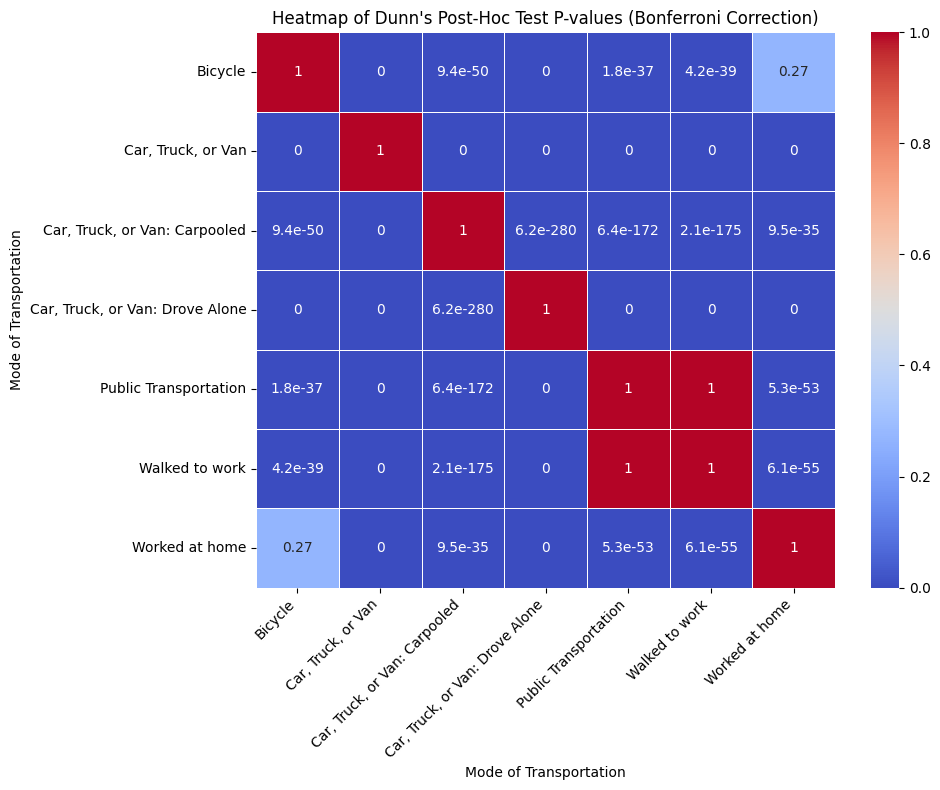


Interpretasi Heatmap:
- Kotak dengan warna lebih dingin (biru) dan nilai p-value kecil (misalnya < 0.05) menunjukkan perbedaan signifikan antar pasangan mode transportasi.
- Kotak dengan warna lebih hangat (merah) dan nilai p-value besar (misalnya >= 0.05) menunjukkan tidak ada perbedaan signifikan antar pasangan mode transportasi.
- Diagonal matriks selalu berwarna hangat dengan p-value 1.00 karena membandingkan mode transportasi dengan dirinya sendiri.


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gunakan matriks p-value dengan nama mode transportasi (dunn_results yang sudah diupdate)
plt.figure(figsize=(10, 8))
sns.heatmap(dunn_results, annot=True, cmap='coolwarm', fmt=".2g", linewidths=.5)
plt.title('Heatmap of Dunn\'s Post-Hoc Test P-values (Bonferroni Correction)')
plt.xlabel('Mode of Transportation')
plt.ylabel('Mode of Transportation')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nInterpretasi Heatmap:")
print("- Kotak dengan warna lebih dingin (biru) dan nilai p-value kecil (misalnya < 0.05) menunjukkan perbedaan signifikan antar pasangan mode transportasi.")
print("- Kotak dengan warna lebih hangat (merah) dan nilai p-value besar (misalnya >= 0.05) menunjukkan tidak ada perbedaan signifikan antar pasangan mode transportasi.")
print("- Diagonal matriks selalu berwarna hangat dengan p-value 1.00 karena membandingkan mode transportasi dengan dirinya sendiri.")

In [12]:
!pip install scikit-posthocs

Setelah library terinstal, kita bisa melanjutkan dengan uji Dunn's.

In [13]:
import scikit_posthocs as sp

# Siapkan data dalam format yang dibutuhkan oleh scikit-posthocs
# Diperlukan list of arrays or a dataframe with values and groups
data_for_dunn = [group['percent'].dropna().values for name, group in df.groupby('mode_name')]
groups_names = [name for name, group in df.groupby('mode_name')]

# Lakukan uji Dunn's
# p_adjust='bonferroni' adalah salah satu metode koreksi p-value yang umum
dunn_results = sp.posthoc_dunn(data_for_dunn, p_adjust='bonferroni')

# Tampilkan hasil (biasanya dalam bentuk matriks p-value)
print("=== Hasil Uji Post-Hoc Dunn's (dengan koreksi Bonferroni) ===")
display(dunn_results)

# Untuk interpretasi yang lebih mudah, kita bisa memetakan indeks ke nama mode
dunn_results.columns = groups_names
dunn_results.index = groups_names

print("\n=== Matriks P-value Uji Dunn's (dengan Nama Mode Transportasi) ===")
display(dunn_results)

print("\nInterpretasi: Nilai p-value yang kurang dari 0.05 menunjukkan perbedaan signifikan antara pasangan mode transportasi tersebut.")

=== Hasil Uji Post-Hoc Dunn's (dengan koreksi Bonferroni) ===


,1,2,3,4,5,6,7
1,1.000000e+00,0.0,9.428598e-50,0.000000e+00,1.794321e-37,4.160261e-39,2.663508e-01
2,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,9.428598e-50,0.0,1.000000e+00,6.151692e-280,6.371929e-172,2.084405e-175,9.475619e-35
4,0.000000e+00,0.0,6.151692e-280,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,1.794321e-37,0.0,6.371929e-172,0.000000e+00,1.000000e+00,1.000000e+00,5.349409e-53
6,4.160261e-39,0.0,2.084405e-175,0.000000e+00,1.000000e+00,1.000000e+00,6.128523e-55
7,2.663508e-01,0.0,9.475619e-35,0.000000e+00,5.349409e-53,6.128523e-55,1.000000e+00



=== Matriks P-value Uji Dunn's (dengan Nama Mode Transportasi) ===


,Bicycle,"Car, Truck, or Van","Car, Truck, or Van: Carpooled","Car, Truck, or Van: Drove Alone",Public Transportation,Walked to work,Worked at home
Bicycle,1.000000e+00,0.0,9.428598e-50,0.000000e+00,1.794321e-37,4.160261e-39,2.663508e-01
"Car, Truck, or Van",0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
"Car, Truck, or Van: Carpooled",9.428598e-50,0.0,1.000000e+00,6.151692e-280,6.371929e-172,2.084405e-175,9.475619e-35
"Car, Truck, or Van: Drove Alone",0.000000e+00,0.0,6.151692e-280,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Public Transportation,1.794321e-37,0.0,6.371929e-172,0.000000e+00,1.000000e+00,1.000000e+00,5.349409e-53
Walked to work,4.160261e-39,0.0,2.084405e-175,0.000000e+00,1.000000e+00,1.000000e+00,6.128523e-55
Worked at home,2.663508e-01,0.0,9.475619e-35,0.000000e+00,5.349409e-53,6.128523e-55,1.000000e+00



Interpretasi: Nilai p-value yang kurang dari 0.05 menunjukkan perbedaan signifikan antara pasangan mode transportasi tersebut.


### Uji Kruskal-Wallis

Karena asumsi normalitas dan homogenitas varians untuk ANOVA tidak terpenuhi, kita akan menggunakan uji Kruskal-Wallis sebagai alternatif non-parametrik. Uji ini akan memeriksa apakah ada perbedaan signifikan dalam distribusi (lebih tepatnya, median) 'percent' di antara berbagai mode transportasi.

In [11]:
from scipy.stats import kruskal

# Siapkan data untuk uji Kruskal-Wallis
# Kumpulkan data 'percent' untuk setiap mode_name dalam list, hilangkan nilai NaN
kruskal_data = [group['percent'].dropna() for name, group in df.groupby('mode_name')]

# Lakukan uji Kruskal-Wallis
stat, p = kruskal(*kruskal_data)

print("=== Hasil Uji Kruskal-Wallis ===")
print(f"Kruskal-Wallis H statistic = {stat:.4f}")
print(f"p-value                     = {p:.6f}")

if p < 0.05:
    print("Kesimpulan                 : Terdapat perbedaan signifikan antar mode_name (p < 0.05)")
else:
    print("Kesimpulan                 : Tidak terdapat perbedaan signifikan antar mode_name (p >= 0.05)")

=== Hasil Uji Kruskal-Wallis ===
Kruskal-Wallis H statistic = 44425.9484
p-value                     = 0.000000
Kesimpulan                 : Terdapat perbedaan signifikan antar mode_name (p < 0.05)


#### 2. Uji Homogenitas Varians (menggunakan Levene's Test)

Kita akan memeriksa apakah varians 'percent' sama di seluruh kelompok 'mode_name'.

In [9]:
from scipy.stats import levene

# Siapkan data untuk uji Levene
# Kumpulkan data 'percent' untuk setiap mode_name dalam list
levene_data = [group['percent'].dropna() for name, group in df.groupby('mode_name')]

# Lakukan uji Levene
stat, p = levene(*levene_data)

print("=== Levene's Test for Homogeneity of Variances ===")
print(f"Statistic = {stat:.4f}, p-value = {p:.4f}")

if p < 0.05:
    print("Kesimpulan: Varians TIDAK homogen (p < 0.05)")
else:
    print("Kesimpulan: Varians homogen (p >= 0.05)")

=== Levene's Test for Homogeneity of Variances ===
Statistic = 1798.3693, p-value = 0.0000
Kesimpulan: Varians TIDAK homogen (p < 0.05)


#### 3. Visualisasi untuk Normalitas dan Outliers

Visualisasi seperti histogram dan box plot dapat memberikan gambaran tambahan mengenai distribusi data dan keberadaan outlier yang mungkin mempengaruhi asumsi normalitas.


=== Histograms for selected modes ===


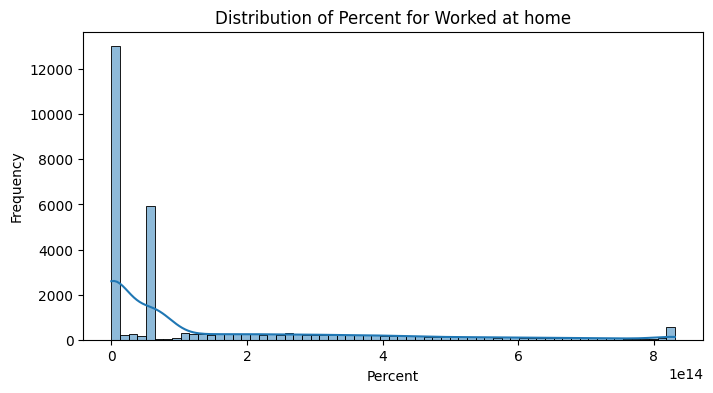

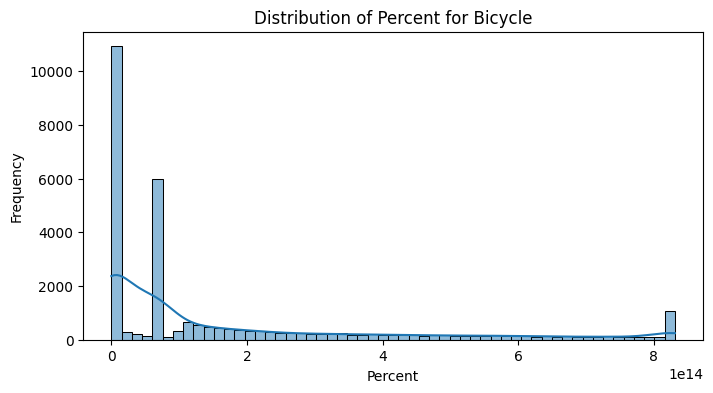

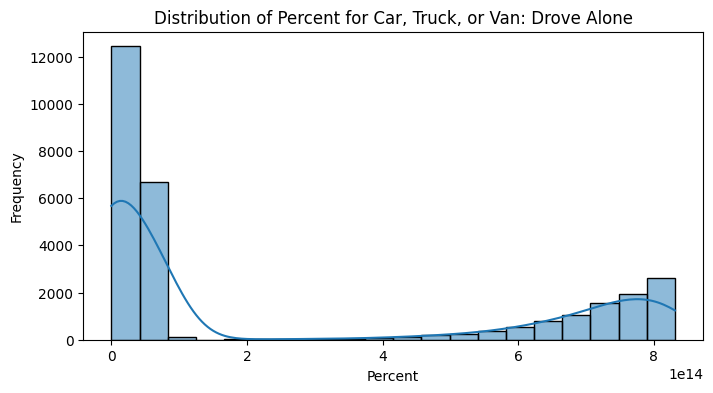

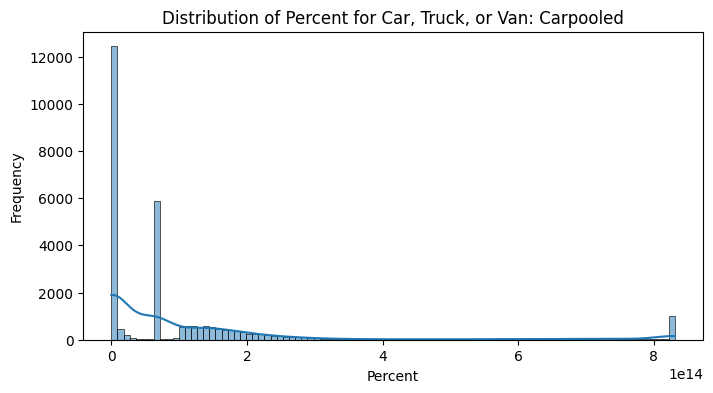

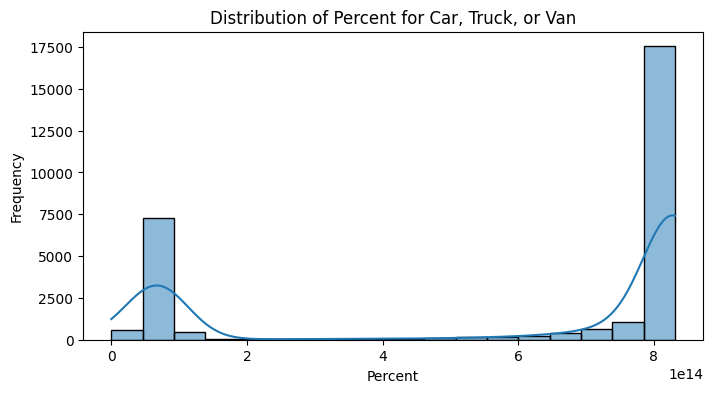


=== Box plot for selected modes ===


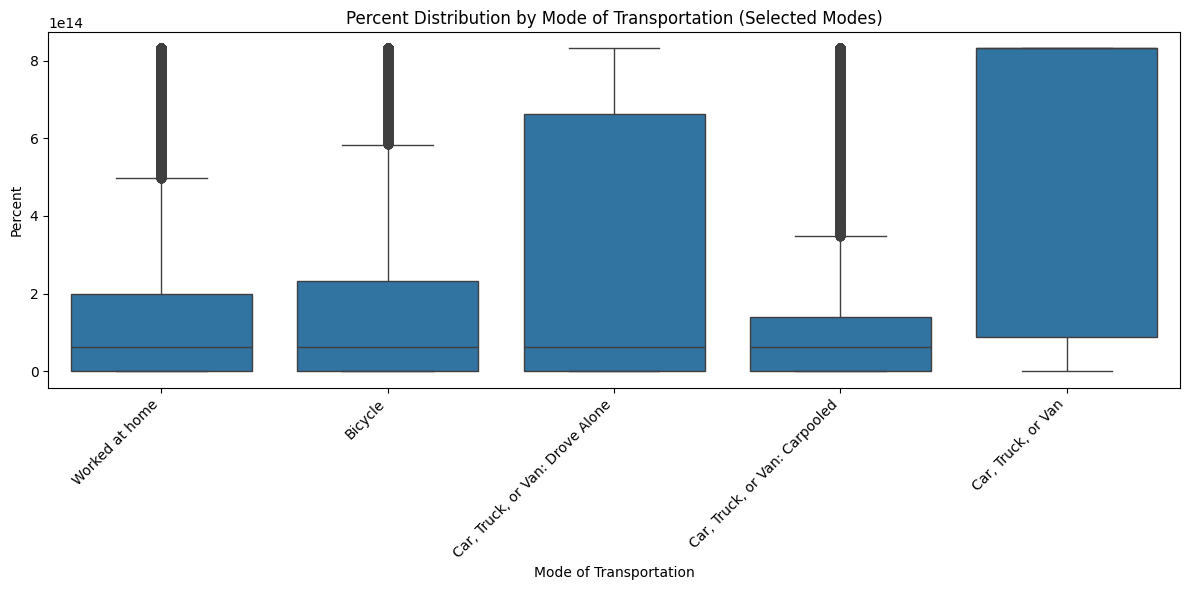

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram untuk beberapa mode_name
print("\n=== Histograms for selected modes ===")
for mode in selected_modes:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[df['mode_name'] == mode]['percent'].dropna(), kde=True)
    plt.title(f'Distribution of Percent for {mode}')
    plt.xlabel('Percent')
    plt.ylabel('Frequency')
    plt.show()

# Box plot untuk perbandingan antar mode_name (sampel kecil agar tidak terlalu padat)
print("\n=== Box plot for selected modes ===")
plt.figure(figsize=(12, 6))
sns.boxplot(x='mode_name', y='percent', data=df[df['mode_name'].isin(selected_modes)])
plt.title('Percent Distribution by Mode of Transportation (Selected Modes)')
plt.xlabel('Mode of Transportation')
plt.ylabel('Percent')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Ringkasan Hasil Pengujian Statistik

Berikut adalah ringkasan dari pengujian statistik yang telah dilakukan:

1.  **Uji ANOVA (Awal):**
    *   **Tujuan:** Menguji apakah ada perbedaan signifikan rata-rata 'percent' antar kelompok 'mode_name'.
    *   **Hasil:** Ditemukan perbedaan signifikan (p-value sangat kecil).
    *   **Catatan:** Uji ini bersifat parametrik dan mengasumsikan normalitas dan homogenitas varians.

2.  **Pemeriksaan Asumsi ANOVA:**
    *   **Uji Normalitas (Shapiro-Wilk):**
        *   **Tujuan:** Memeriksa apakah data 'percent' terdistribusi normal di setiap kelompok 'mode_name'.
        *   **Hasil:** Data di sebagian besar kelompok **TIDAK** terdistribusi normal (p-value < 0.05).
    *   **Uji Homogenitas Varians (Levene's):**
        *   **Tujuan:** Memeriksa apakah varians 'percent' sama di seluruh kelompok 'mode_name'.
        *   **Hasil:** Varians **TIDAK** homogen (p-value < 0.05).
    *   **Kesimpulan Asumsi:** Asumsi normalitas dan homogenitas varians untuk uji ANOVA **TIDAK terpenuhi**.

3.  **Uji Kruskal-Wallis (Alternatif Non-Parametrik):**
    *   **Tujuan:** Menguji apakah ada perbedaan signifikan dalam distribusi/median 'percent' antar kelompok 'mode_name' (alternatif non-parametrik untuk ANOVA).
    *   **Hasil:** Ditemukan perbedaan signifikan (p-value sangat kecil). Ini mengkonfirmasi hasil ANOVA dengan metode yang tidak mengasumsikan normalitas dan homogenitas varians.

4.  **Uji Post-Hoc Dunn's:**
    *   **Tujuan:** Mengidentifikasi pasangan 'mode_name' mana saja yang memiliki perbedaan signifikan dalam 'percent' setelah uji Kruskal-Wallis yang signifikan.
    *   **Hasil:** Matriks p-value dan heatmap menunjukkan bahwa **mayoritas pasangan mode transportasi memiliki perbedaan signifikan** dalam persentase penggunaannya (p-value < 0.05 untuk sebagian besar pasangan). Hanya beberapa pasangan yang mungkin tidak menunjukkan perbedaan signifikan.

### Kesimpulan Akhir

Berdasarkan serangkaian pengujian statistik yang telah dilakukan, termasuk uji non-parametrik Kruskal-Wallis dan post-hoc Dunn's (yang lebih sesuai karena pelanggaran asumsi ANOVA), dapat disimpulkan dengan kuat bahwa **terdapat perbedaan yang signifikan dalam persentase penggunaan antar berbagai mode transportasi**.

Uji Dunn's lebih lanjut merinci bahwa perbedaan signifikan ini ada pada **hampir semua pasangan mode transportasi** yang dibandingkan. Ini berarti bahwa pola penggunaan transportasi sangat bervariasi tergantung pada jenis mode transportasi yang dipilih.

Untuk interpretasi spesifik pasangan mode transportasi mana yang berbeda, lihat kembali heatmap dari uji Dunn's; kotak dengan p-value < 0.05 (warna biru) menunjukkan perbedaan yang signifikan.

In [17]:
# Filter data untuk mode transportasi yang relevan dengan kemacetan
congestion_modes = ['Car, Truck, or Van: Drove Alone', 'Car, Truck, or Van: Carpooled', 'Public Transportation']
df_congestion = df[df['mode_name'].isin(congestion_modes)]

# Tampilkan statistik deskriptif untuk 'percent' pada mode-mode ini
print("=== Statistik Deskriptif untuk 'percent' pada Mode Terkait Kemacetan ===")
display(df_congestion.groupby('mode_name')['percent'].describe())

# Hitung persentase total pengguna kendaraan pribadi vs transportasi publik (jika data memungkinkan)
# Ini mungkin memerlukan agregasi lebih lanjut atau mempertimbangkan kolom pop_total
# Untuk saat ini, kita fokus pada persentase per mode seperti di kolom 'percent'

=== Statistik Deskriptif untuk 'percent' pada Mode Terkait Kemacetan ===


,count,mean,std,min,25%,50%,75%,max
mode_name,,,,,,,,
"Car, Truck, or Van: Carpooled",28886.0,1.156303e+14,1.967419e+14,0.0,124.0,6.339144e+13,1.390569e+14,8.311068e+14
"Car, Truck, or Van: Drove Alone",28886.0,2.534409e+14,3.326137e+14,0.0,773.0,6.339144e+13,6.619147e+14,8.311068e+14
Public Transportation,28886.0,1.247077e+14,2.097841e+14,0.0,18.0,4.308739e+13,1.375020e+14,8.311068e+14


In [24]:
import kagglehub
import pandas as pd

# Gunakan KaggleDatasetAdapter
from kagglehub import KaggleDatasetAdapter

# Tentukan dataset dari Kaggle
dataset = "amitzala/transportation-dataset"
file_path = "transportation-to-work-1.xlsx"

# Load dataset menggunakan KaggleHub, kali ini JANGAN HANYA MEMILIH SUBSET KOLOM DIAWAL
# Load seluruh data terlebih dahulu
df_original = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    dataset,
    file_path,
    pandas_kwargs={"sheet_name": 0}
)

# Tampilkan informasi dasar dataset untuk memastikan kolom geografis ada
print("=== Informasi Dataset Setelah Reload ===")
print(df_original.info())

# Sekarang, kita bisa melanjutkan analisis dengan DataFrame yang lengkap (df_original)
# Ganti nama DataFrame yang akan digunakan untuk analisis agar tidak menimpa df sebelumnya
df_analysis = df_original.copy()

# Lakukan langkah-langkah pra-pemrosesan yang relevan (jika diperlukan untuk kolom yang akan dianalisis)
# Berdasarkan analisis sebelumnya, 'reportyear', 'pop_total', dan 'percent' sudah diolah.
# Kita perlu memastikan kolom 'mode_name' dan 'region_name' bersih jika ada NaN.

# Imputasi nilai kosong pada kolom yang relevan untuk analisis ini jika ada
# Berdasarkan df.isna().sum() sebelumnya:
# region_name       112939 (banyak NaN, ini akan mempengaruhi analisis per region)
# mode_name              1
# pop_total          40846
# percent            40972
# reportyear             1

# Untuk analisis per region, baris dengan region_name NaN tidak bisa diikutsertakan
df_analysis = df_analysis.dropna(subset=['region_name'])

# Imputasi sisa kolom yang relevan jika masih ada NaN setelah dropna(subset)
# Gunakan mode untuk object, median untuk numerik seperti sebelumnya
for col in ['mode_name']:
    if df_analysis[col].isnull().any():
        mode_val = df_analysis[col].mode()
        if not mode_val.empty:
            df_analysis[col] = df_analysis[col].fillna(mode_val[0])

for col in ['pop_total', 'percent']:
     # Pastikan kolom numerik sebelum imputasi median
     if pd.api.types.is_numeric_dtype(df_analysis[col]):
        if df_analysis[col].isnull().any():
            median_val = df_analysis[col].median()
            df_analysis[col] = df_analysis[col].fillna(median_val)
     else:
         # Jika masih ada non-numerik setelah pembersihan awal, coba konversi dengan coerce
         df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')
         if df_analysis[col].isnull().any():
             median_val = df_analysis[col].median()
             df_analysis[col] = df_analysis[col].fillna(median_val)


# Filter data untuk mode 'Car, Truck, or Van: Drove Alone' dari DataFrame yang sudah diolah
drove_alone_region_df = df_analysis[df_analysis['mode_name'] == 'Car, Truck, or Van: Drove Alone'].copy()

# Hitung rata-rata persentase 'Drove Alone' per region
region_congestion_potential = drove_alone_region_df.groupby('region_name')['percent'].mean().reset_index()

# Urutkan dari persentase tertinggi untuk melihat region dengan potensi kemacetan tertinggi
region_congestion_potential = region_congestion_potential.sort_values(by='percent', ascending=False)

print("\n=== Potensi Kemacetan Berdasarkan Rata-rata Persentase Pengguna 'Drove Alone' per Region ===")
display(region_congestion_potential)

print("\nInterpretasi:")
print("- Region dengan rata-rata persentase pengguna 'Car, Truck, or Van: Drove Alone' yang lebih tinggi memiliki potensi kemacetan yang lebih besar.")
print("- Perlu diingat bahwa kolom 'region_name' memiliki banyak nilai kosong di data asli, jadi analisis ini hanya berdasarkan data yang tersedia untuk region yang terdefinisi.")

/tmp/ipython-input-1803944967.py:13: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df_original = kagglehub.load_dataset(


Using Colab cache for faster access to the 'transportation-dataset' dataset.
=== Informasi Dataset Setelah Reload ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202203 entries, 0 to 202202
Data columns (total 24 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   ind_id          202203 non-null  object        
 1   ind_definition  202202 non-null  object        
 2   reportyear      202202 non-null  object        
 3   race_eth_code   202202 non-null  float64       
 4   race_eth_name   202202 non-null  object        
 5   geotype         202202 non-null  object        
 6   geotypevalue    202202 non-null  float64       
 7   geoname         202202 non-null  object        
 8   county_name     200298 non-null  object        
 9   county_fips     200298 non-null  float64       
 10  region_name     89264 non-null   object        
 11  region_code     89264 non-null   float64       
 12  mode            202202 n

,region_name,percent
13,Southern California,64.109665
8,San Diego,63.342725
0,Bay Area,57.822728
7,Sacramento Area,56.999320
3,Monterey Bay,53.523432
11,Santa Barbara,53.305040
9,San Joaquin Valley,49.508334
10,San Luis Obispo,49.373800
12,Shasta,47.937990
1,Butte,46.844680



Interpretasi:
- Region dengan rata-rata persentase pengguna 'Car, Truck, or Van: Drove Alone' yang lebih tinggi memiliki potensi kemacetan yang lebih besar.
- Perlu diingat bahwa kolom 'region_name' memiliki banyak nilai kosong di data asli, jadi analisis ini hanya berdasarkan data yang tersedia untuk region yang terdefinisi.



=== Rata-rata Persentase Pengguna per Mode Terkait Kemacetan ===


,mode_name,percent
0,"Car, Truck, or Van: Carpooled",1.156303e+14
1,"Car, Truck, or Van: Drove Alone",2.534409e+14
2,Public Transportation,1.247077e+14


/tmp/ipython-input-1904409152.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mode_name', y='percent', data=avg_percent_congestion_modes, palette='viridis')


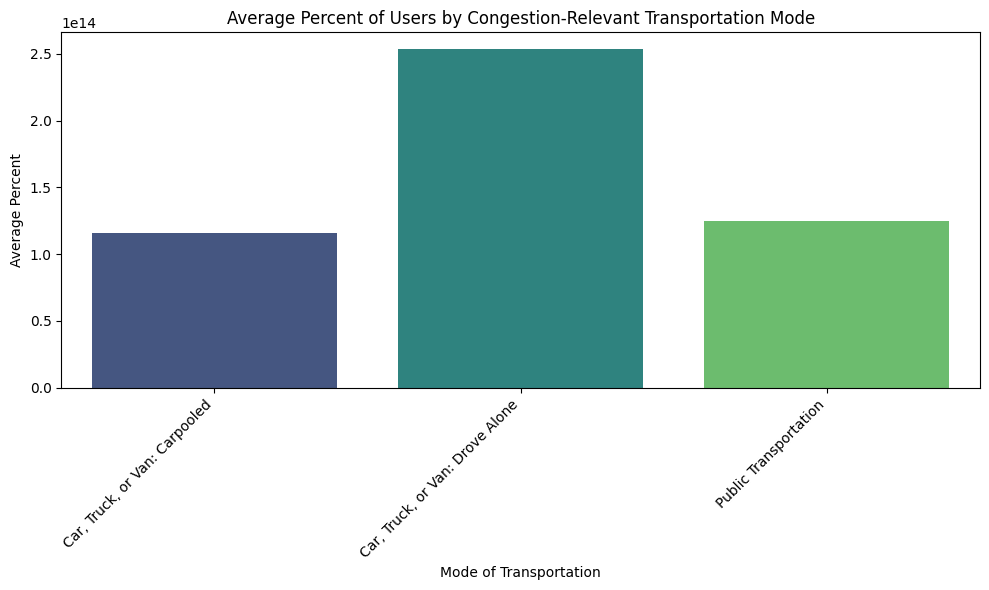

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data untuk mode transportasi yang relevan dengan kemacetan (sudah dilakukan sebelumnya)
# congestion_modes = ['Car, Truck, or Van: Drove Alone', 'Car, Truck, or Van: Carpooled', 'Public Transportation']
# df_congestion = df[df['mode_name'].isin(congestion_modes)]

# Hitung rata-rata persentase untuk mode-mode ini
avg_percent_congestion_modes = df_congestion.groupby('mode_name')['percent'].mean().reset_index()

print("\n=== Rata-rata Persentase Pengguna per Mode Terkait Kemacetan ===")
display(avg_percent_congestion_modes)


# Buat bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='mode_name', y='percent', data=avg_percent_congestion_modes, palette='viridis')
plt.title('Average Percent of Users by Congestion-Relevant Transportation Mode')
plt.xlabel('Mode of Transportation')
plt.ylabel('Average Percent')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Extracting numeric year for Public Transportation data...

=== Rata-rata Persentase Pengguna 'Public Transportation' per Tahun ===


,reportyear_numeric,percent
0,2000,2.467119e+14
1,2005,1.061687e+14
2,2006,4.211299e+12
3,2008,1.115094e+14



=== Gabungan Data Tren Kedua Mode ===


,reportyear_numeric,percent,Mode
0,2000,5.172767e+14,"Car, Truck, or Van: Drove Alone"
1,2005,1.578346e+14,"Car, Truck, or Van: Drove Alone"
2,2006,6.050516e+12,"Car, Truck, or Van: Drove Alone"
3,2008,1.753490e+14,"Car, Truck, or Van: Drove Alone"
0,2000,2.467119e+14,Public Transportation
1,2005,1.061687e+14,Public Transportation
2,2006,4.211299e+12,Public Transportation
3,2008,1.115094e+14,Public Transportation


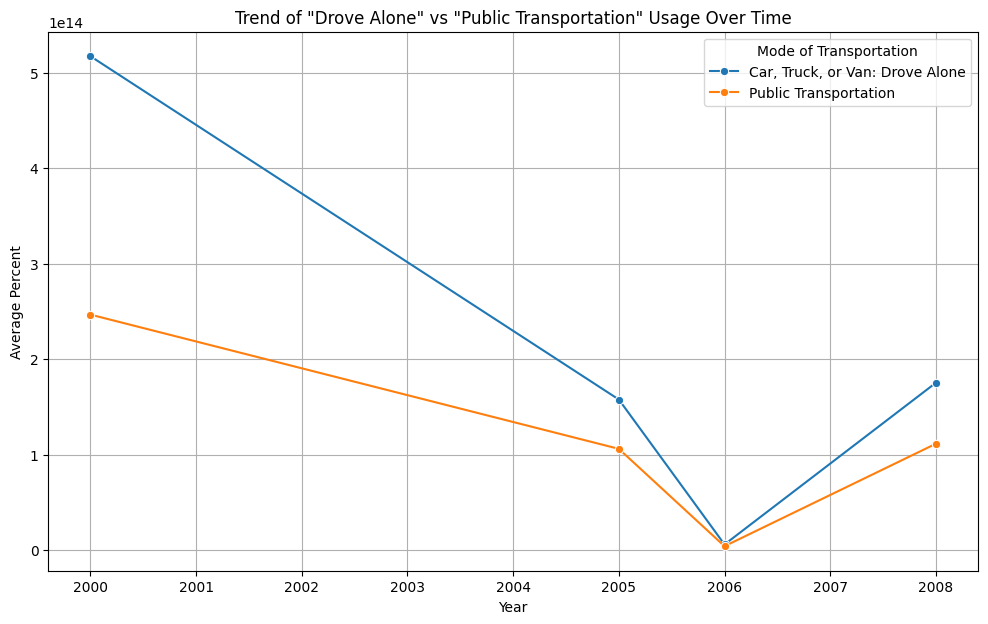

In [22]:
# Filter data untuk mode 'Public Transportation'
public_transport_df = df[df['mode_name'] == 'Public Transportation'].copy()

# Pastikan 'reportyear' adalah tipe data yang sesuai dan ekstrak tahun numerik
# Gunakan fungsi extract_year yang sudah didefinisikan sebelumnya jika perlu
if 'reportyear_numeric' not in public_transport_df.columns:
    print("Extracting numeric year for Public Transportation data...")
    def extract_year(year_str):
        if pd.isna(year_str):
            return None
        try:
            return int(year_str) # Try direct conversion first
        except ValueError:
            if isinstance(year_str, str) and '-' in year_str:
                try:
                    return int(year_str.split('-')[0]) # Extract start year from range
                except ValueError:
                    return None
            return None # Return None for other unexpected formats

    public_transport_df['reportyear_numeric'] = public_transport_df['reportyear'].apply(extract_year)
    public_transport_df = public_transport_df.dropna(subset=['reportyear_numeric'])


# Group by reportyear and calculate the mean percent for Public Transportation
public_transport_trend = public_transport_df.groupby('reportyear_numeric')['percent'].mean().reset_index()

print("\n=== Rata-rata Persentase Pengguna 'Public Transportation' per Tahun ===")
display(public_transport_trend)

# Gabungkan data tren untuk kedua mode untuk plotting
drove_alone_trend['Mode'] = 'Car, Truck, or Van: Drove Alone'
public_transport_trend['Mode'] = 'Public Transportation'

combined_trend_df = pd.concat([drove_alone_trend, public_transport_trend])

print("\n=== Gabungan Data Tren Kedua Mode ===")
display(combined_trend_df)

# Plot tren kedua mode pada satu grafik
plt.figure(figsize=(12, 7))
sns.lineplot(x='reportyear_numeric', y='percent', hue='Mode', data=combined_trend_df, marker='o')
plt.title('Trend of "Drove Alone" vs "Public Transportation" Usage Over Time')
plt.xlabel('Year')
plt.ylabel('Average Percent')
plt.grid(True)
plt.legend(title='Mode of Transportation')
plt.show()

In [26]:
# Filter data untuk mode 'Car, Truck, or Van: Drove Alone'
# Gunakan df_analysis yang sudah dimuat ulang dan memiliki kolom geografis
drove_alone_county_df = df_analysis[df_analysis['mode_name'] == 'Car, Truck, or Van: Drove Alone'].copy()

# Pastikan kolom county_name tidak kosong pada subset ini
drove_alone_county_df = drove_alone_county_df.dropna(subset=['county_name'])

# Hitung rata-rata persentase 'Drove Alone' per county
county_congestion_potential = drove_alone_county_df.groupby('county_name')['percent'].mean().reset_index()

# Urutkan dari persentase tertinggi untuk melihat county dengan potensi kemacetan tertinggi
county_congestion_potential = county_congestion_potential.sort_values(by='percent', ascending=False)

print("=== Potensi Kemacetan Berdasarkan Rata-rata Persentase Pengguna 'Drove Alone' per County ===")
display(county_congestion_potential.head(10)) # Tampilkan 10 county dengan potensi tertinggi
display(county_congestion_potential.tail(10)) # Tampilkan 10 county dengan potensi terendah

print("\nInterpretasi:")
print("- County dengan rata-rata persentase pengguna 'Car, Truck, or Van: Drove Alone' yang lebih tinggi memiliki potensi kemacetan yang lebih besar.")
print("- Data ini hanya indikasi berdasarkan satu faktor (penggunaan mobil pribadi sendirian) dan tidak secara langsung mengukur tingkat kemacetan sebenarnya.")

=== Potensi Kemacetan Berdasarkan Rata-rata Persentase Pengguna 'Drove Alone' per County ===


,county_name,percent
29,Orange,72.675942
42,Santa Clara,67.970219
18,Los Angeles,65.787669
47,Solano,65.551593
0,Alameda,64.691248
55,Ventura,64.647046
36,San Diego,62.969571
35,San Bernardino,62.472849
40,San Mateo,62.228016
33,Sacramento,61.705696


,county_name,percent
22,Mendocino,34.183215
13,Inyo,33.111150
17,Lassen,32.867144
52,Trinity,30.875336
1,Alpine,23.339323
24,Modoc,22.013827
31,Plumas,18.866688
21,Mariposa,18.619423
45,Sierra,16.884769
25,Mono,15.128770



Interpretasi:
- County dengan rata-rata persentase pengguna 'Car, Truck, or Van: Drove Alone' yang lebih tinggi memiliki potensi kemacetan yang lebih besar.
- Data ini hanya indikasi berdasarkan satu faktor (penggunaan mobil pribadi sendirian) dan tidak secara langsung mengukur tingkat kemacetan sebenarnya.


from matplotlib import pyplot as plt
_df_0['percent'].plot(kind='hist', bins=20, title='percent')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['percent'].plot(kind='line', figsize=(8, 4), title='percent')
plt.gca().spines[['top', 'right']].set_visible(False)